<a href="https://colab.research.google.com/github/sauce-Git/DAP/blob/main/insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# **Insurance data**
나이, 성별, bmi, 자녀수, 흡연 여부, 지역, 보험금에 관한 데이터 입니다.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# **Outlier**
Outlier을 제거하여 데이터의 품질을 높입니다.


In [3]:
Q1 = df['charges'].quantile(.20)
Q3 = df['charges'].quantile(.70)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR

filtered_df = df[df['charges'] < Q3 + outlier_step]

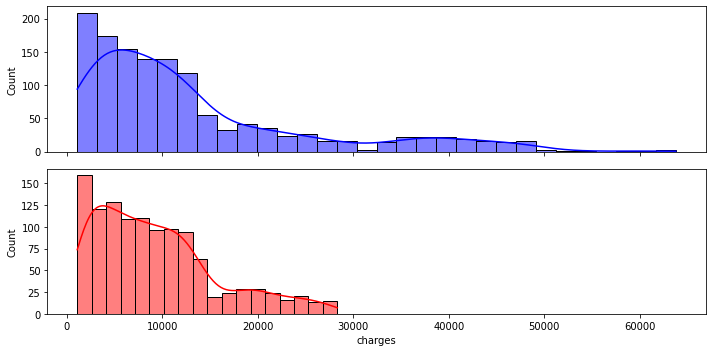

In [4]:
f, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

sns.histplot(data=df, x='charges', ax=axes[0], color='Blue', kde='True')
sns.histplot(data=filtered_df, x='charges', ax=axes[1], color='Red', kde='True')

f.tight_layout()

# **DownSampling**
Smoker과 non-Smoker의 수를 맞추어 줍니다.

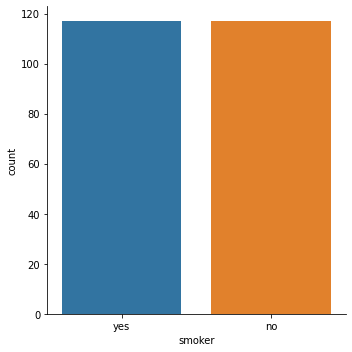

In [5]:
num_0 = sum(filtered_df.smoker=='yes')
num_1 = sum(filtered_df.smoker=='no')

undersampledDf = pd.concat([filtered_df[filtered_df['smoker']=='yes'].sample(num_0), 
                            filtered_df[filtered_df['smoker']=='no'].sample(num_0)])

sns.catplot(data=undersampledDf, kind="count", x='smoker')

plt.show()

# **Encoding**
smoker, region 열을 encoding합니다.

In [6]:
enc = LabelEncoder()

dfEnc = undersampledDf.copy()

for col in ('sex','smoker', 'region'):
  dfEnc[col] = enc.fit_transform(undersampledDf[col])

dfEnc.head()

,age,sex,bmi,children,smoker,region,charges
638,39,1,26.41,0,1,0,20149.3229
750,37,0,26.40,0,1,2,19539.2430
741,27,1,29.15,0,1,2,18246.4955
857,25,1,24.13,0,1,1,15817.9857
989,24,0,20.52,0,1,0,14571.8908


# **Correlation**
데이터 간의 연관성을 계산합니다.

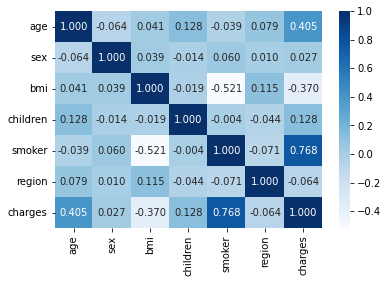

In [7]:
corr = dfEnc.corr(method='spearman')
ax = sns.heatmap(corr, annot=True, fmt='.3f', cmap='Blues')

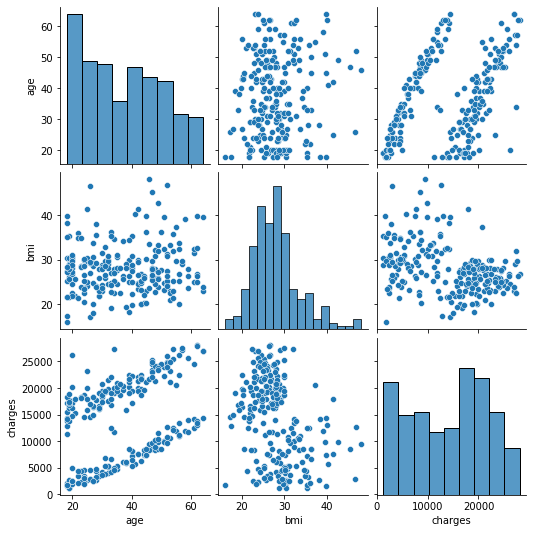

In [8]:
targetVar = ['age', 'bmi', 'charges']
g = sns.pairplot(undersampledDf, vars = targetVar)

# **BMI**
BMI분포도를 나타냅니다.

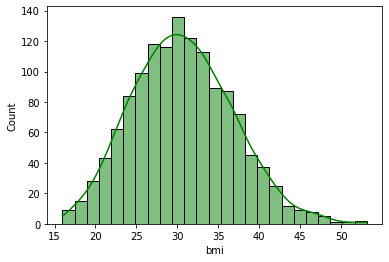

In [9]:
sns.histplot(data=df, x='bmi', color='green', kde=True)

흡연 여부에 따른 BMI분포도를 나타냅니다.

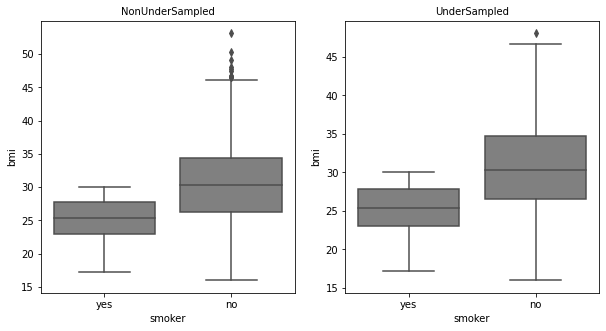

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.boxplot(color = "grey", x='smoker', y='bmi', data=filtered_df, ax=axes[0])
sns.boxplot(color = "grey", x='smoker', y='bmi', data=undersampledDf, ax=axes[1])

axes[0].set_title('NonUnderSampled', fontsize=10)
axes[1].set_title('UnderSampled', fontsize=10)

plt.show()

# **Charges**
age, smokers에 따른 charges의 변화를 분석합니다.

비흡연자와 흡연자로 나누어 새로운 dataframe을 생성합니다.

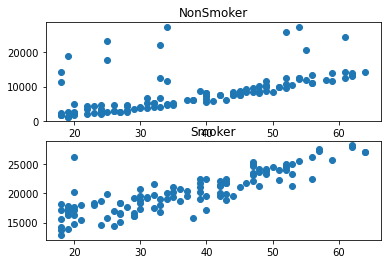

In [11]:
dfNonsmoker = undersampledDf[undersampledDf.smoker=="no"]
dfsmoker = undersampledDf[undersampledDf.smoker=="yes"]

plt.subplot(2, 1, 1)
plt.plot(dfNonsmoker["age"], dfNonsmoker['charges'], 'o')
plt.title('NonSmoker')

plt.subplot(2, 1, 2)
plt.plot(dfsmoker["age"], dfsmoker['charges'], 'o')
plt.title('Smoker')

plt.show()

일차 선형회귀를 사용하여 각 그룹에서의 선형 모델을 생성합니다.

**Smoker Group**

In [12]:
LR1 = LinearRegression()
LR2 = LinearRegression()

x1 = dfNonsmoker[['age']] #independent attribute
y1 = dfNonsmoker[['charges']] #dependent attribute

x2 = dfsmoker[['age']]
y2 = dfsmoker[['charges']] 

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.3, random_state=25) #splitting into training set, test set
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state=25) 

LR1.fit(x_train1, y_train1)
LR2.fit(x_train2, y_train2)

LinearRegression()

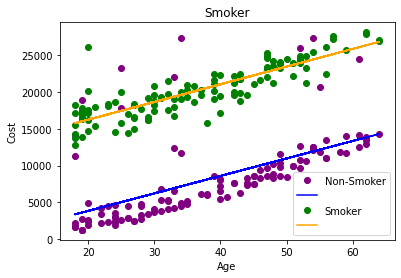

In [13]:
plt.plot(x1, y1, 'o', color='purple')
plt.plot(x1, LR1.predict(x1), color='blue')
plt.plot(x2, y2, 'o', color='green')
plt.plot(x2, LR2.predict(x2), color='orange')
plt.title('Smoker')
plt.xlabel('Age')
plt.ylabel('Cost')
plt.legend(['Non-Smoker','','Smoker',''])

**Evaluation**

r2 score을 이용하여 모델을 평가합니다.

In [14]:
y_prediction1 = LR1.predict(x_test1)
score1=r2_score(y_test1, y_prediction1)
y_prediction2 = LR2.predict(x_test2)
score2=r2_score(y_test2, y_prediction2)

print('r2 score 1 : %.3f'%score1)
print('r2 score 2 : %.3f'%score2)

r2 score 1 : 0.442
r2 score 2 : 0.710
